# Few shot learning pour la classification de signaux


In [1]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassConfusionMatrix
import math

np.random.seed(24)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Used device : {device}")

Used device : cuda:0


## Data vizualisation

In [4]:
# Import des données

def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

train_path = 'train.hdf5' # contient les classes 0 à 6
validation_path = 'validation.hdf5' # contient les classes 0 à 6

sample_path = 'endroll.hdf5' # contient un nombre réduits de signaux des classes 6 à 11
test_path = 'test_fewshot.hdf5'  # test contenant des signaux des classes 6 à 11


train = h5py.File(train_path , 'r')
sample = h5py.File(sample_path, 'r')
test = h5py.File(test_path, 'r')
val  =  h5py.File(validation_path, 'r')

signals_train = np.array(train['signaux'])
snr_train =  np.array(train['snr'])
labels_id_train = np.array(train['labels'])

signals_sample = np.array(sample['signaux'])
snr_sample =  np.array(sample['snr'])
labels_id_sample = np.array(sample['labels'])

signals_val = np.array(val['signaux'])
snr_val =  np.array(val['snr'])
labels_id_val = np.array(val['labels'])

signals_test = np.array(test['signaux'])
snr_test =  np.array(test['snr'])
labels_id_test = np.array(test['labels'])

sample.close()
train.close()
val.close()
test.close()

### Affichage du nombre de sample par classes par label par SNR

In [5]:
for id in range(12):
  if id < 6: # labels du train
    print(f'amount of data for label = {id} : {np.where(labels_id_train==id)[0].shape}')
  else:
    print(f"amount of data for label = {id} : {np.where(labels_id_sample==id)[0].shape}")

print("----------------------------------------------")
for snr in [0, 10, 20, 30]:
    for id_ in range(12):
      if id_ < 6 :
        mask = (snr_train == snr) & (labels_id_train == id_)
        count = mask.sum()
        print(f"Amount of data for snr = {snr} and label = {id_}: {count}")
      else:
        mask = (snr_sample == snr) & (labels_id_sample == id_)
        count = mask.sum()
        print(f"Amount of data for snr = {snr} and label = {id_}: {count}")


amount of data for label = 0 : (5143,)
amount of data for label = 1 : (4968,)
amount of data for label = 2 : (5053,)
amount of data for label = 3 : (4867,)
amount of data for label = 4 : (4894,)
amount of data for label = 5 : (5075,)
amount of data for label = 6 : (93,)
amount of data for label = 7 : (99,)
amount of data for label = 8 : (78,)
amount of data for label = 9 : (66,)
amount of data for label = 10 : (75,)
amount of data for label = 11 : (89,)
----------------------------------------------
Amount of data for snr = 0 and label = 0: 1318
Amount of data for snr = 0 and label = 1: 1219
Amount of data for snr = 0 and label = 2: 1282
Amount of data for snr = 0 and label = 3: 1247
Amount of data for snr = 0 and label = 4: 1274
Amount of data for snr = 0 and label = 5: 1320
Amount of data for snr = 0 and label = 6: 0
Amount of data for snr = 0 and label = 7: 0
Amount of data for snr = 0 and label = 8: 0
Amount of data for snr = 0 and label = 9: 0
Amount of data for snr = 0 and label 

### Plot IQ constellations

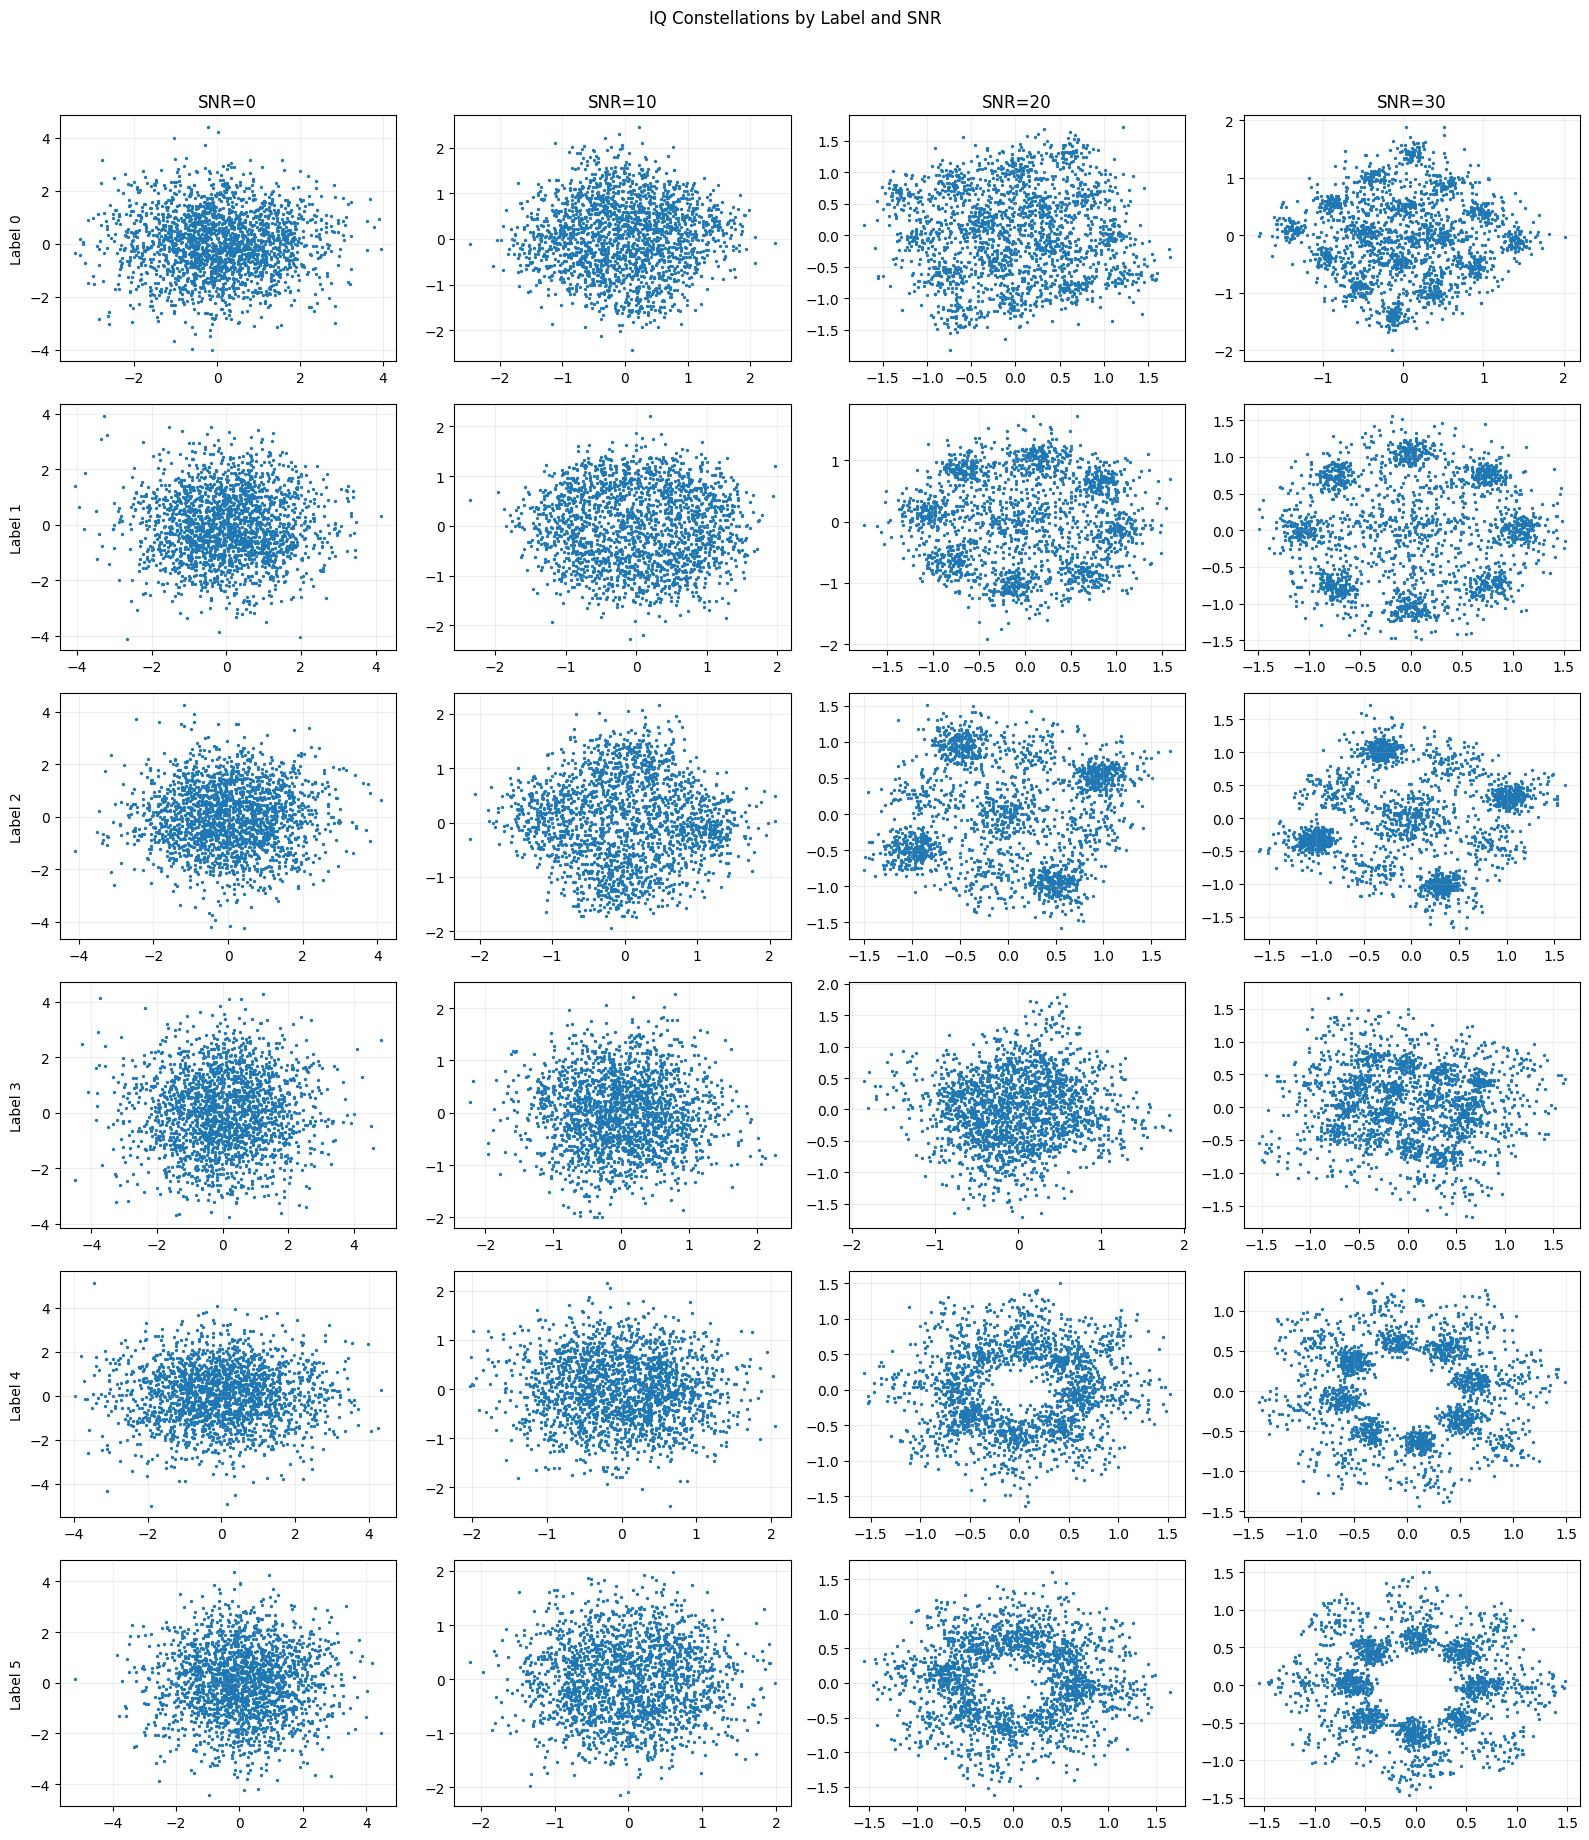

In [6]:
snr_values_train = [0, 10, 20, 30]
labels = [0,1,2,3,4,5]

fig, axes = plt.subplots(
    nrows=len(labels),
    ncols=len(snr_values_train),
    figsize=(4 * len(snr_values_train), 3 * len(labels)),

)

for i, lbl in enumerate(labels):
    for j, snr in enumerate(snr_values_train):
        ax = axes[i, j]

        # indices for this (label, snr)
        mask = (labels_id_train == lbl) & (snr_train == snr)
        idx = np.where(mask)[0]

        if len(idx) == 0:
            ax.set_axis_off()
            continue

        sig = signals_train[idx[0]]          # shape (2048, 2)
        I = sig[:, 0]
        Q = sig[:, 1]

        ax.scatter(I, Q, s=2)
        ax.grid(alpha=0.2)

        if i == 0:
            ax.set_title(f"SNR={snr}")
        if j == 0:
            ax.set_ylabel(f"Label {lbl}")

fig.suptitle("IQ Constellations by Label and SNR", y=1.02)
plt.tight_layout()
plt.show()


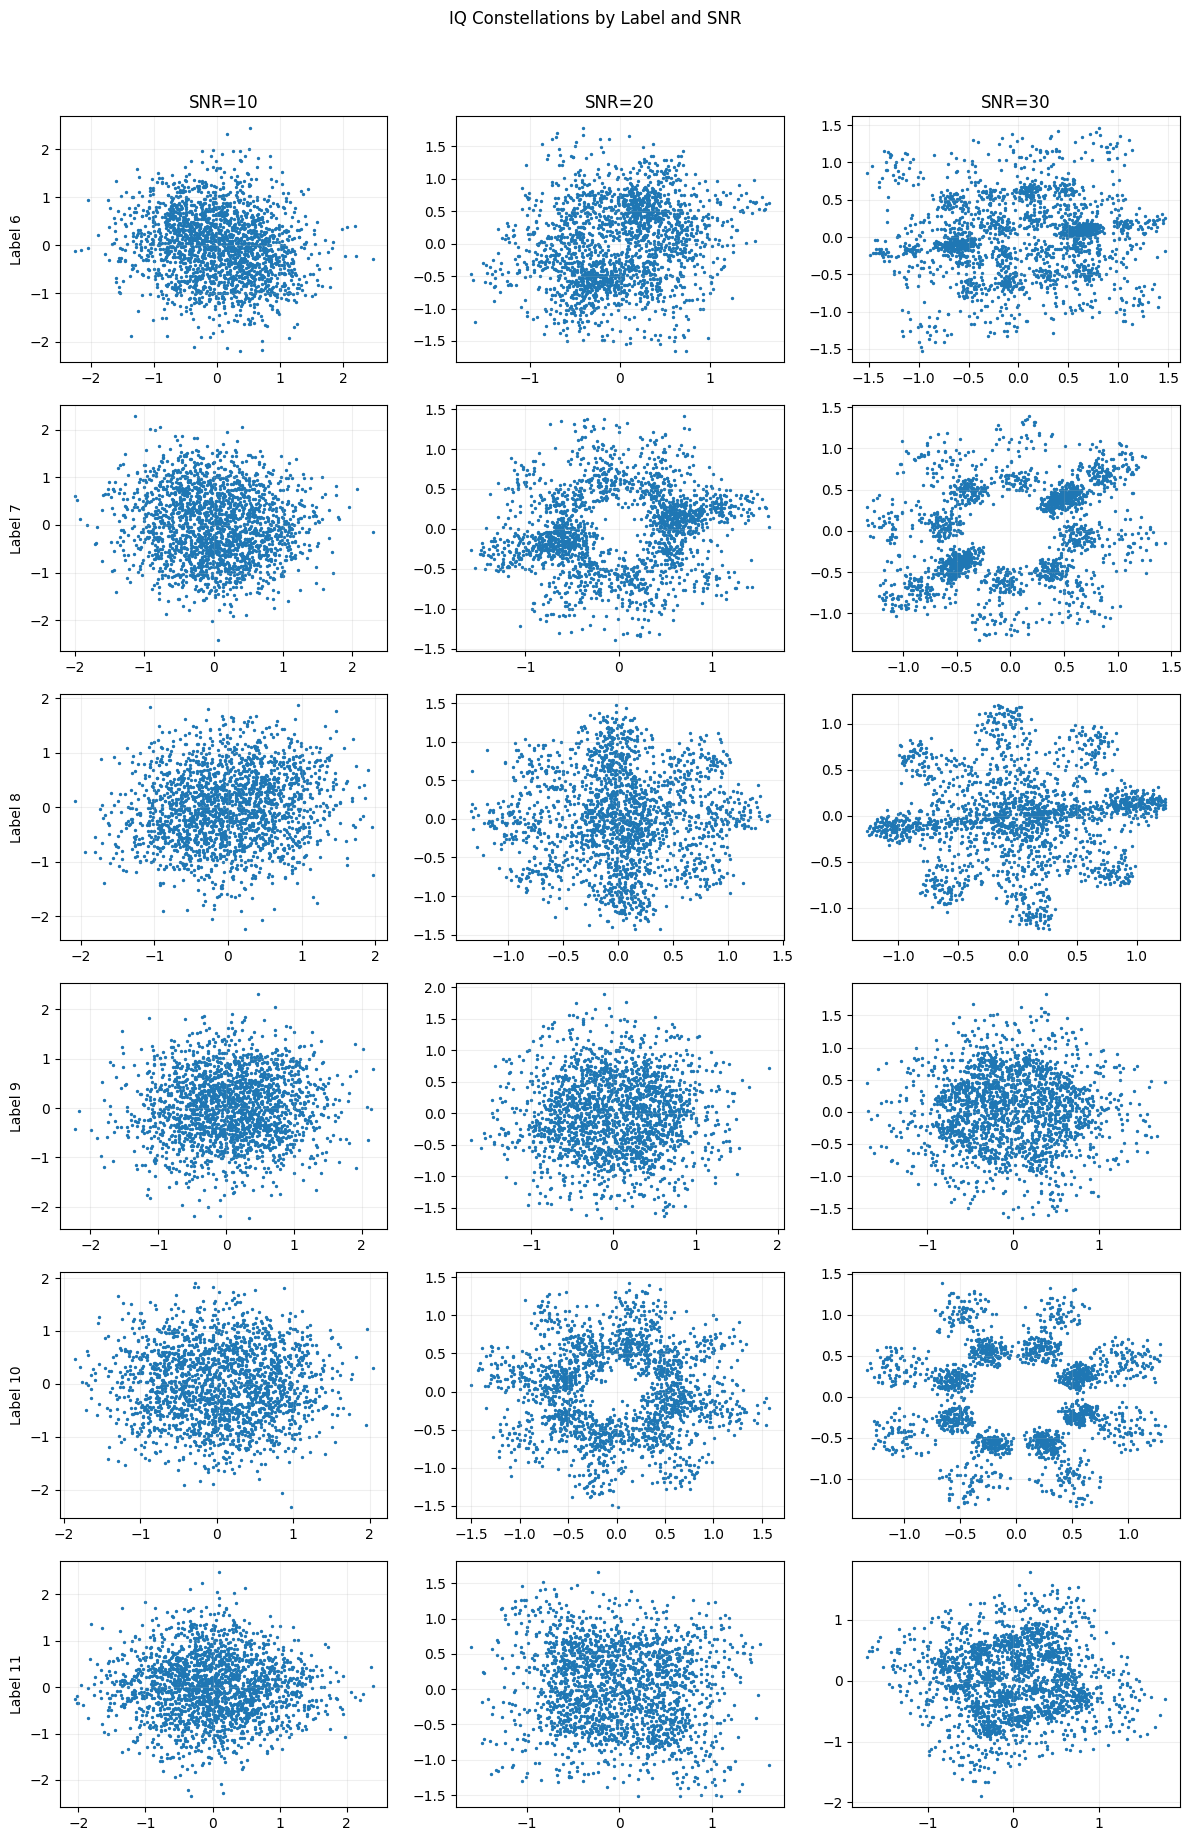

In [7]:
snr_values_sample = [10, 20, 30]
labels = [i for i in range(6,12)]

fig, axes = plt.subplots(
    nrows=len(labels),
    ncols=len(snr_values_sample),
    figsize=(4*len(snr_values_sample),3*len(labels))
)

for i, lbl in enumerate(labels):

  for j, snr in enumerate(snr_values_sample):
    ax = axes[i, j]

    # indices for this (label, snr)
    mask = (labels_id_sample == lbl) & (snr_sample == snr)
    idx = np.where(mask)[0]

    if len(idx) == 0:
      ax.set_axis_off()
      continue

    sig = signals_sample[idx[0]]  # (2048, 2)
    I = sig[:, 0]
    Q = sig[:, 1]

    ax.scatter(I, Q, s=2)
    ax.grid(alpha=0.2)

    if i == 0:
      ax.set_title(f"SNR={snr}")
    if j == 0:
      ax.set_ylabel(f"Label {lbl}")

fig.suptitle("IQ Constellations by Label and SNR", y=1.02)
plt.tight_layout()
plt.show()


## Creation du dataset 

In [8]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    self.data = h5py.File(path , 'r')
    self.signals = torch.transpose(torch.tensor(np.array(self.data['signaux'])),1,2)
    self.labels = torch.tensor(np.array(self.data['labels']))
    self.snr = torch.tensor(np.array(self.data['snr']))
    self.data.close()
  def __len__(self):
    return self.signals.shape[0]
  def __getitem__(self,i):
    return self.signals[i],self.snr[i],self.labels[i]

## Création du réseau de neuronnes avec SNR embedding
    

In [12]:
class Reseau(nn.Module):
    def __init__(self, in_channels=2, n_classes=6,snr_emb = 8,mult=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 16*mult, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),              # reduction par 2 augmente le champ récepteur

            nn.Conv1d(16*mult, 32*mult, kernel_size=7, padding=3), # 7, 3 pour garder la même dimmension (avec le padding)
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32*mult, 32*mult, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),  # réduire par deux
        )

        # EMBedding sur snr
        self.snr_embedding = nn.Sequential(
            nn.Linear(1,snr_emb),
            nn.ReLU(),
            nn.Linear(snr_emb,snr_emb),
            nn.ReLU(),
        )
        # Classification après pooling global
        self.classifier = nn.Linear(32*mult+snr_emb, n_classes)

    def forward(self, x,snr):
        logsnr = torch.log(snr + 10) # +10 juste pour éviter log(0)
        snr_emb = self.snr_embedding(logsnr)
        x = self.features(x)              # (B, 64, L')
        x = x.mean(dim=-1)  # B, 64
        embedding = torch.concat([x,snr_emb],dim=1) # (B, 72)
        x = self.classifier(embedding)            # (B, n_classes)
        return embedding, F.log_softmax(x, dim=1)    # on renvoie a la fois l'embedding et le vecteur de proba


In [13]:
model = Reseau()

def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

print(f"Total amount of parameters of the model : {count_n_param(model)}")

Total amount of parameters of the model : 11390


## Trainning baseline : 
- on entraîne directement un classifieur supervisé sur les classes 6–11 uniquement, en limitant volontairement le nombre d’exemples disponibles par classe (nb_sample). Concrètement, pour chaque nb_sample on construit un split stratifié avec au moins 20% de validation par label, puis on entraîne le même réseau (Conv1D + embedding SNR + couche linéaire) avec une NLLLoss.

#### Utils pour sélectionner un nombre fixe de samples pour le trainning


In [14]:
def make_train_val_indices(dataset, nb_sample, val_frac_min=0.2, seed=0):
    y = dataset.labels
    uniq = torch.unique(y).tolist()

    g = torch.Generator()
    g.manual_seed(int(seed))

    train_idx_chunks, val_idx_chunks = [], []

    for lab in uniq:
        idx = torch.nonzero(y == lab, as_tuple=False).squeeze(1)
        idx = idx[torch.randperm(idx.numel(), generator=g)]  # shuffle

        n_total = idx.numel()
        n_val_min = int(np.ceil(val_frac_min * n_total))
        n_val_min = min(n_total, max(1, n_val_min))  # >=1 si possible

        n_train = min(int(nb_sample), n_total - n_val_min)

        train_idx_chunks.append(idx[:n_train])
        val_idx_chunks.append(idx[n_train:])  # val = min + reste

    train_idx = torch.cat(train_idx_chunks).tolist() if len(train_idx_chunks) else []
    val_idx   = torch.cat(val_idx_chunks).tolist() if len(val_idx_chunks) else []
    return train_idx, val_idx, uniq

def print_split_debug(dataset, train_idx, val_idx, uniq):
    y = dataset.labels
    ytr = y[train_idx]
    yva = y[val_idx]
    print(f"Train size={len(train_idx)} | Val size={len(val_idx)}")
    for lab in uniq:
        ntot = int((y == lab).sum().item())
        ntr  = int((ytr == lab).sum().item()) if len(train_idx) else 0
        nva  = int((yva == lab).sum().item()) if len(val_idx) else 0
        pct  = 100.0 * nva / max(1, ntot)
        print(f"  label={lab}: train={ntr}, val={nva} (total={ntot}, val%={pct:.1f}%)")

### saving paths

In [16]:
EXP_NAME = '500_epoch'
BASE_DIR = os.getcwd()
RUN_DIR = os.path.join(BASE_DIR,'runs_baseline')
EXP_DIR = os.path.join(RUN_DIR,EXP_NAME)
LOSS_DIR = os.path.join(EXP_DIR,'losses')
WEIGHTS_DIR = os.path.join(EXP_DIR,'weights')

os.makedirs(EXP_DIR,exist_ok=True)
os.makedirs(LOSS_DIR,exist_ok=True)
os.makedirs(WEIGHTS_DIR,exist_ok=True)


### trainning 

In [25]:
max_samples = [1,5,10,20,50,100] # nombre max de samples utilisés par class
for nb_sample in max_samples : 
    batch_size = max(2,nb_sample)

    model_pth_name = f'model_baseline_max_samples_{nb_sample}.pth'
    
    model_baseline= Reseau().to(device)
    loss = nn.NLLLoss() # il faut renvoyer des log prob pas des prob
    optimizer = torch.optim.Adam(model_baseline.parameters())
    
    dataset_sample = MyDataset(sample_path)
    # 6-11 to 0-5 pour NLL loss
    dataset_sample.labels = dataset_sample.labels.long()-6


    train_idx,val_idx,uniq = make_train_val_indices(dataset_sample,nb_sample)
    print_split_debug(dataset_sample,train_idx,val_idx,uniq)

    dataloader_train = DataLoader(Subset(dataset_sample,train_idx),batch_size=batch_size,shuffle=True)
    dataloader_val = DataLoader(Subset(dataset_sample,val_idx),batch_size=batch_size)
    
    n_epochs = 500

    val_acc_history_name = f'val_acc_max_samples_{nb_sample}.npy'
    train_acc_history_name = f'train_acc_max_samples_{nb_sample}.npy'
    train_loss_history_name = f'train_loss_max_samples_{nb_sample}.npy'
    val_loss_history_name = f'val_loss_max_samples_{nb_sample}.npy'

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):

        model_baseline.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for step, (b, snr,label) in enumerate(dataloader_train, start=1):
            b = b.to(device)
            label = label.long().to(device)
            snr = snr.unsqueeze(-1).to(device)
            # print(snr.shape)

            optimizer.zero_grad()

            _,outputs = model_baseline(b,snr)                 
            l = loss(outputs, label)

            l.backward()
            optimizer.step()

            running_loss += l.item() * b.size(0)

            # calcul accuracy
            preds = outputs.argmax(dim=1)
            correct_train += (preds == label).sum().item()
            total_train += label.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model_baseline.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for b, snr,label in dataloader_val:
                b = b.to(device)
                label = label.long().to(device)
                snr = snr.unsqueeze(-1).to(device)


                _,outputs = model_baseline(b,snr)
                l_val = loss(outputs, label)

                val_running_loss += l_val.item()*b.size(0)

                preds = outputs.argmax(dim=1)
                correct_val += (preds==label).sum().item()
                total_val+= label.size(0)

        epoch_val_loss = val_running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(
            f"Epoch {epoch+1}/{n_epochs} "
            f"- train loss={epoch_train_loss:.4f}, train acc={epoch_train_acc*100:.2f}% "
            f"- val loss={epoch_val_loss:.4f}, val acc={epoch_val_acc*100:.2f}%"
        )

    epochs = np.arange(1, n_epochs + 1)

    torch.save(model_baseline.state_dict(), os.path.join(WEIGHTS_DIR,model_pth_name))
    print(f"Model saved to {os.path.join(WEIGHTS_DIR,model_pth_name)}")
    np.save(os.path.join(LOSS_DIR, val_acc_history_name),   np.array(val_acc_history))
    np.save(os.path.join(LOSS_DIR, train_acc_history_name), np.array(train_acc_history))
    np.save(os.path.join(LOSS_DIR, val_loss_history_name),  np.array(val_loss_history))
    np.save(os.path.join(LOSS_DIR, train_loss_history_name),np.array(train_loss_history))



    

Train size=6 | Val size=494
  label=0: train=1, val=92 (total=93, val%=98.9%)
  label=1: train=1, val=98 (total=99, val%=99.0%)
  label=2: train=1, val=77 (total=78, val%=98.7%)
  label=3: train=1, val=65 (total=66, val%=98.5%)
  label=4: train=1, val=74 (total=75, val%=98.7%)
  label=5: train=1, val=88 (total=89, val%=98.9%)
Epoch 1/500 - train loss=1.8233, train acc=16.67% - val loss=1.8210, val acc=13.16%
Epoch 2/500 - train loss=1.8065, train acc=16.67% - val loss=1.8207, val acc=13.16%
Epoch 3/500 - train loss=1.8046, train acc=16.67% - val loss=1.8185, val acc=13.16%
Epoch 4/500 - train loss=1.8025, train acc=16.67% - val loss=1.8174, val acc=13.16%
Epoch 5/500 - train loss=1.8039, train acc=16.67% - val loss=1.8147, val acc=13.16%
Epoch 6/500 - train loss=1.7997, train acc=16.67% - val loss=1.8141, val acc=13.16%
Epoch 7/500 - train loss=1.8014, train acc=16.67% - val loss=1.8119, val acc=13.16%
Epoch 8/500 - train loss=1.7983, train acc=16.67% - val loss=1.8109, val acc=13.16%


### Performances de la baseline
* On affiche :  courbes train/val loss et train/val accuracy, confusion matrix sur le test, ainsi que la test accuracy et l’écart max(train acc) − test acc en fonction de `nb_sample`.


labels min/max after remap: 0 5

==== nb_sample=1 | n_epochs=500 ====
Last epoch: train loss=0.0600, val loss=14.2570, train acc=100.00%, val acc=22.87%


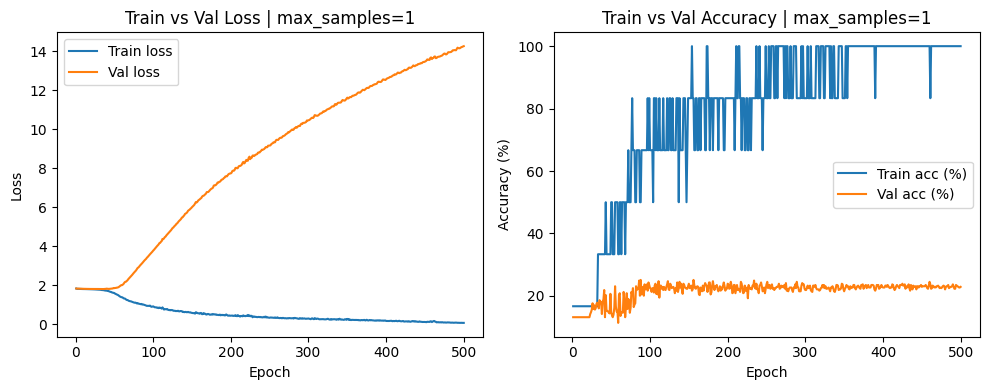

Final test accuracy: 0.2640 (26.40%) | max_samples=1
Confusion matrix:
 [[11  0 41 25  0 13]
 [13  0  7 30  2 22]
 [ 2  0 48 13  0 14]
 [ 0  0 12 19  0 58]
 [ 0  0 32 19  0 32]
 [ 0  0  9 24  0 54]]


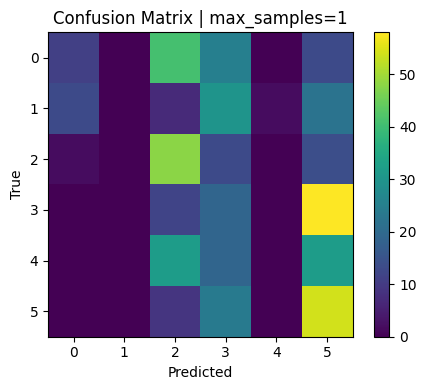


==== nb_sample=5 | n_epochs=500 ====
Last epoch: train loss=0.2196, val loss=3.9666, train acc=96.67%, val acc=39.79%


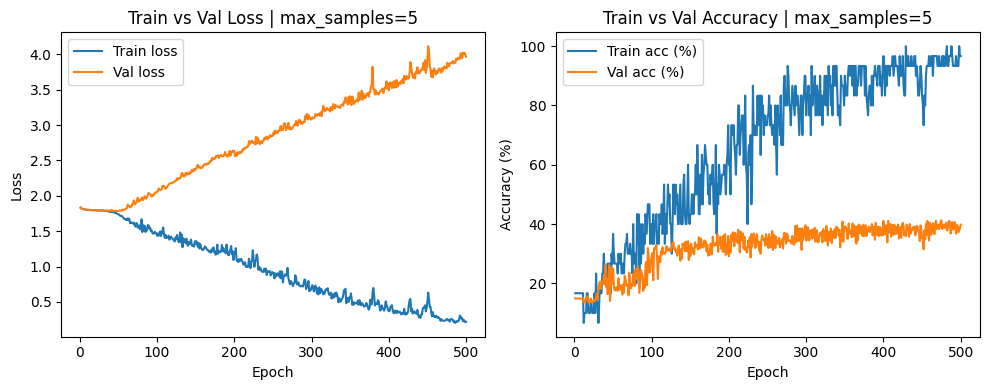

Final test accuracy: 0.4040 (40.40%) | max_samples=5
Confusion matrix:
 [[35 23  1  6 10 15]
 [21 36  0  4  7  6]
 [ 6 21 34  1  6  9]
 [ 0  3  2 14 17 53]
 [ 0  5  2  8 27 41]
 [ 1  5  1  9 15 56]]


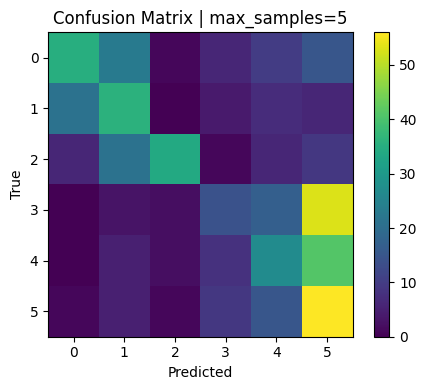


==== nb_sample=10 | n_epochs=500 ====
Last epoch: train loss=0.6659, val loss=1.7177, train acc=80.00%, val acc=39.77%


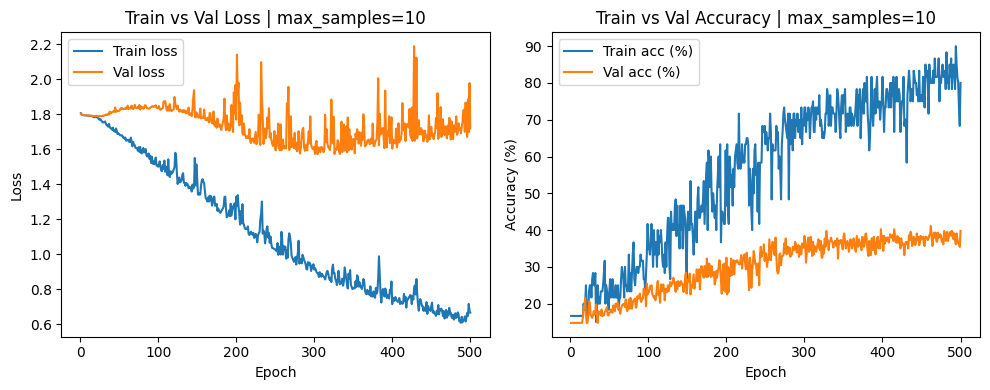

Final test accuracy: 0.3460 (34.60%) | max_samples=10
Confusion matrix:
 [[40 16  0 10 13 11]
 [27 25  0  3  8 11]
 [16  6 35 14  0  6]
 [29 15  0 19  4 22]
 [28 11  0  1 33 10]
 [26 10  1 24  5 21]]


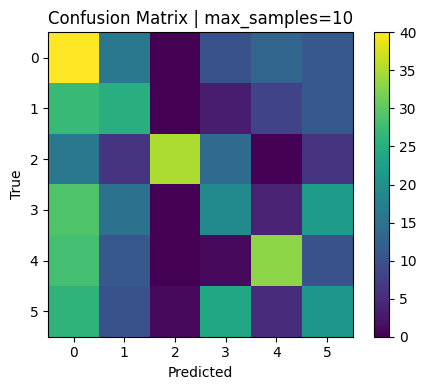


==== nb_sample=20 | n_epochs=500 ====
Last epoch: train loss=0.4848, val loss=1.2299, train acc=81.67%, val acc=46.32%


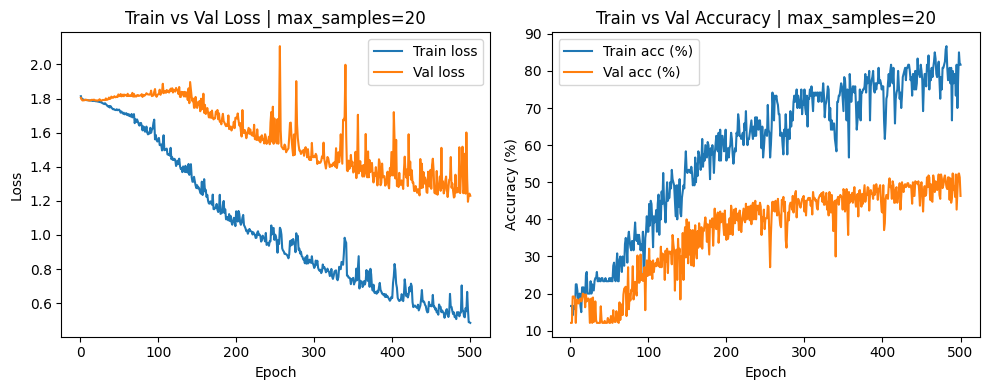

Final test accuracy: 0.4920 (49.20%) | max_samples=20
Confusion matrix:
 [[36 12  2  3 32  5]
 [14 39  0  0 11 10]
 [19  0 51  1  6  0]
 [ 5  6  0 18 12 48]
 [ 1 26  0  0 55  1]
 [ 7 10  0 21  2 47]]


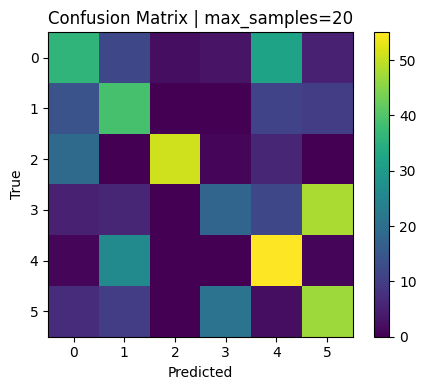


==== nb_sample=50 | n_epochs=500 ====
Last epoch: train loss=0.7185, val loss=0.9737, train acc=73.00%, val acc=51.50%


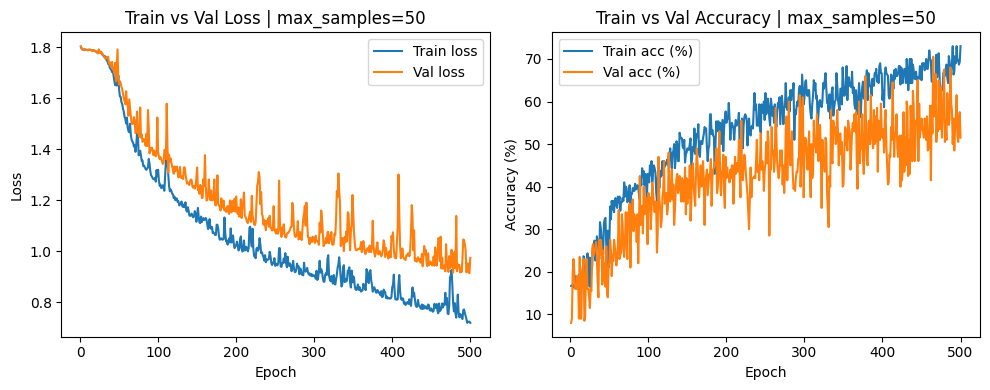

Final test accuracy: 0.5440 (54.40%) | max_samples=50
Confusion matrix:
 [[56  8  1  0 23  2]
 [ 6 27  1  0 39  1]
 [ 0  0 77  0  0  0]
 [21 11  0  8  0 49]
 [ 2 20  1  1 59  0]
 [18 10  0 14  0 45]]


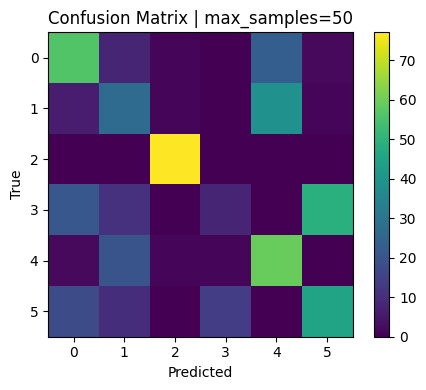


==== nb_sample=100 | n_epochs=500 ====
Last epoch: train loss=0.5597, val loss=0.5943, train acc=73.12%, val acc=70.59%


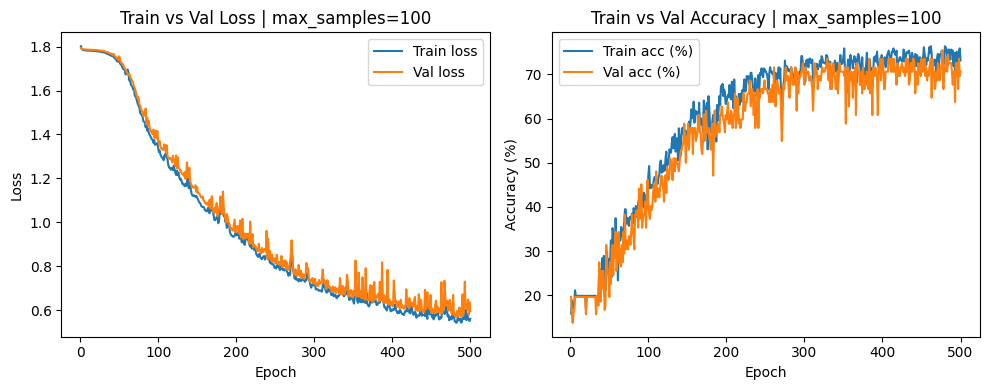

Final test accuracy: 0.6240 (62.40%) | max_samples=100
Confusion matrix:
 [[78  7  0  0  3  2]
 [ 0 50  1  0 23  0]
 [ 0  0 75  0  2  0]
 [32  0  0  0  0 57]
 [ 0 30  1  0 52  0]
 [30  0  0  0  0 57]]


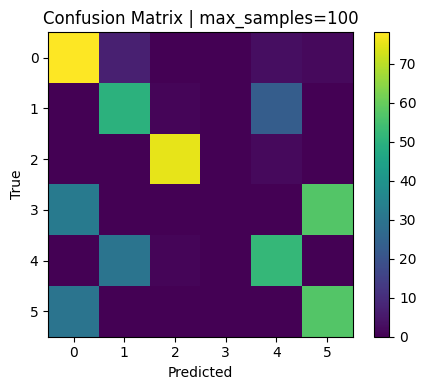

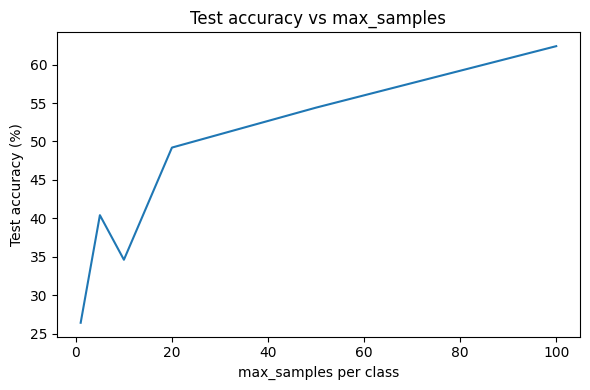

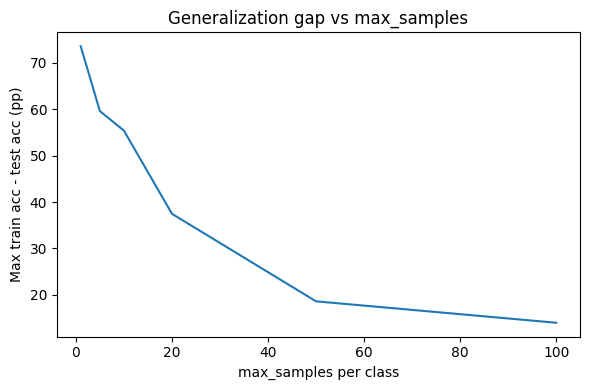

In [29]:
num_classes = 6
max_samples = [1,5, 10, 20, 50, 100]
dataset_test = MyDataset(test_path)
dataset_test.labels = dataset_test.labels.long() - 6
print("labels min/max after remap:", dataset_test.labels.min().item(), dataset_test.labels.max().item())


dataloader_test = DataLoader(dataset_test,batch_size=16)

test_acc_list = []
max_train_acc_list = []
gap_train_test_list = []

# on regarde les perfs pour chaque nb_sample
for nb_sample in max_samples:

    # load des loss et acc de training/val
    val_acc_history_name   = f'val_acc_max_samples_{nb_sample}.npy'
    train_acc_history_name = f'train_acc_max_samples_{nb_sample}.npy'
    train_loss_history_name= f'train_loss_max_samples_{nb_sample}.npy'
    val_loss_history_name  = f'val_loss_max_samples_{nb_sample}.npy'

    train_loss_history = np.load(os.path.join(LOSS_DIR, train_loss_history_name))
    val_loss_history   = np.load(os.path.join(LOSS_DIR, val_loss_history_name))
    train_acc_history  = np.load(os.path.join(LOSS_DIR, train_acc_history_name))
    val_acc_history    = np.load(os.path.join(LOSS_DIR, val_acc_history_name))

 
    max_train_acc = float(np.max(train_acc_history))
    max_train_acc_list.append(max_train_acc)
  

    n_epochs = len(train_loss_history)
    epochs = np.arange(1, n_epochs + 1)

    print(f"\n==== nb_sample={nb_sample} | n_epochs={n_epochs} ====")
    print(f"Last epoch: train loss={train_loss_history[-1]:.4f}, val loss={val_loss_history[-1]:.4f}, "
          f"train acc={100*np.array(train_acc_history[-1]):.2f}%, val acc={100*np.array(val_acc_history[-1]):.2f}%")

    plt.figure(figsize=(10,4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train loss')
    plt.plot(epochs, val_loss_history, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val Loss | max_samples={nb_sample}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, np.array(train_acc_history)*100, label='Train acc (%)')
    plt.plot(epochs, np.array(val_acc_history)*100, label='Val acc (%)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Train vs Val Accuracy | max_samples={nb_sample}')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # load models 
    model_pth_name = f'model_baseline_max_samples_{nb_sample}.pth'
    model_path = os.path.join(WEIGHTS_DIR, model_pth_name)

    model1 = Reseau().to(device)
    model1.load_state_dict(torch.load(model_path, map_location=device))
    model1.eval()

    # confusion matrice sur le test
    cm_metric = MulticlassConfusionMatrix(num_classes=num_classes)
    correct = 0
    total = 0

    with torch.no_grad():
        for b_test, snr_test, label_test in dataloader_test:
            b_test = b_test.to(device)
            label_test = label_test.long().to(device)
            snr_test = snr_test.unsqueeze(-1).to(device)

            out = model1(b_test, snr_test)
            outputs = out[1] if isinstance(out, (tuple, list)) else out

            preds = outputs.argmax(dim=1)

            correct += (preds == label_test).sum().item()
            total += label_test.size(0)

            cm_metric.update(preds.cpu(), label_test.cpu())

    test_acc = correct / max(1, total)
    print(f"Final test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%) | max_samples={nb_sample}")

    test_acc_list.append(float(test_acc))
    gap_train_test_list.append(float(max_train_acc - test_acc))

    cm = cm_metric.compute().numpy()
    print("Confusion matrix:\n", cm)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix | max_samples={nb_sample}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.xticks(range(num_classes))
    plt.yticks(range(num_classes))
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(6, 4))
plt.plot(max_samples, np.array(test_acc_list) * 100)
plt.xlabel('max_samples per class')
plt.ylabel('Test accuracy (%)')
plt.title('Test accuracy vs max_samples')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(max_samples, np.array(gap_train_test_list) * 100)
plt.xlabel('max_samples per class')
plt.ylabel('Max train acc - test acc (pp)')
plt.title('Generalization gap vs max_samples')
plt.tight_layout()
plt.show()
# <<<


# Commentaires resultats baseline : 
Plusieurs choses :

* On voit très clairement que lorsque l’on utilise peu de samples du dataset on overfit très vite (val loss qui augmente pendant le trainning). On a affiché l’écart entre train et test accuracy sur le dernier plot : on voit clairement que l’écart entre les deux diminue quand on augmente `nb_sample`, signe qu’on réduit l’overfitting.

* On obtient donc une méthode baseline très naïve qui commence à performer décemment (60% accuracy) seulement à partir de 50 samples/per label, ce qui fait en soi déjà beacoup de samples.

Au vu de la tête des signaux 6–11, qui sont du même type que 0–5 (ce sont des modulations, donc même famille de signaux ; on le voit clairement quand on les affiche en IQ), on aimerait pouvoir exploiter les nombreux samples 0–5 c'est à dire généraliser ce qu'on apprend sur eux.




## Training prototypical on train dataset with labels 0 to 5

L’idée générale est la suivante : on a 0–5 qui sont globalement des signaux similaires, donc on peut apprendre un encodeur qui extrait des features robustes et qui s’adapte vite à peu de nouvelles données (via episodic training, comme décrit dans le papier), puis l’adapter sur nos nouvelles classes 6–11.

Description rapide des étapes de la méthode/entrainement high level

In [31]:


EXP_NAME_PROTO = "exp1"
RUN_DIR_PROTO = os.path.join(BASE_DIR, "runs_prototypes")
EXP_DIR_PROTO = os.path.join(RUN_DIR_PROTO, EXP_NAME_PROTO)
LOSS_DIR_PROTO = os.path.join(EXP_DIR_PROTO, "losses")
WEIGHTS_DIR_PROTO = os.path.join(EXP_DIR_PROTO, "weights")

os.makedirs(EXP_DIR_PROTO, exist_ok=True)
os.makedirs(LOSS_DIR_PROTO, exist_ok=True)
os.makedirs(WEIGHTS_DIR_PROTO, exist_ok=True)


In [32]:

# datasets base (0-5)
dataset_train = MyDataset(train_path)
dataset_val   = MyDataset(validation_path)

# We get rid of samples where SNR == 0
mask_train = dataset_train.snr != 0
mask_val   = dataset_val.snr != 0

dataset_train.signals = dataset_train.signals[mask_train]
dataset_train.snr     = dataset_train.snr[mask_train]
dataset_train.labels  = dataset_train.labels[mask_train]

dataset_val.signals = dataset_val.signals[mask_val]
dataset_val.snr     = dataset_val.snr[mask_val]
dataset_val.labels  = dataset_val.labels[mask_val]

print("Train base size (snr!=0):", len(dataset_train), "| Val base size (snr!=0):", len(dataset_val))
print("Train labels:", torch.unique(dataset_train.labels).tolist(), "| Val labels:", torch.unique(dataset_val.labels).tolist())
print("Train snr min/max:", dataset_train.snr.min().item(), dataset_train.snr.max().item())

# --- D_k tensors 
D_k_tensors = {}
D_k_val_tensors = {}

for k in range(6):
    mask_k = (dataset_train.labels == k)
    mask_kv = (dataset_val.labels == k)
    D_k_tensors[k] = (dataset_train.signals[mask_k], dataset_train.snr[mask_k], dataset_train.labels[mask_k])
    D_k_val_tensors[k] = (dataset_val.signals[mask_kv], dataset_val.snr[mask_kv], dataset_val.labels[mask_kv])

# ------------------------------------------------------------
# Episode sampling + prototypical loss (inchangé)
# ------------------------------------------------------------
@torch.no_grad()
def _sample_episode(D_k_tensors, class_ids, N_s, N_q, device):
    support_x, support_snr, support_y = [], [], []
    query_x, query_snr, query_y = [], [], []

    for new_y, k in enumerate(class_ids):
        Xk, SNRk, _ = D_k_tensors[int(k)]
        Xk = Xk.float()
        SNRk = SNRk.float()

        n = Xk.shape[0]
        m = N_s + N_q

        if n >= m:
            idx = torch.randperm(n)[:m]
        else:
            idx = torch.randint(0, n, (m,))

        s_idx = idx[:N_s]
        q_idx = idx[N_s:]

        support_x.append(Xk[s_idx])
        support_snr.append(SNRk[s_idx])
        support_y.append(torch.full((N_s,), new_y, dtype=torch.long))

        query_x.append(Xk[q_idx])
        query_snr.append(SNRk[q_idx])
        query_y.append(torch.full((N_q,), new_y, dtype=torch.long))

    support_x = torch.cat(support_x, dim=0).to(device)
    support_snr = torch.cat(support_snr, dim=0).to(device).unsqueeze(1)
    support_y = torch.cat(support_y, dim=0).to(device)

    query_x = torch.cat(query_x, dim=0).to(device)
    query_snr = torch.cat(query_snr, dim=0).to(device).unsqueeze(1)
    query_y = torch.cat(query_y, dim=0).to(device)

    return support_x, support_snr, support_y, query_x, query_snr, query_y

def prototypical_loss(model, D_k_tensors, N_s, N_q, N_c, device):
    K = len(D_k_tensors)
    class_ids = torch.randperm(K)[:N_c]

    support_x, support_snr, _, query_x, query_snr, query_y = _sample_episode(
        D_k_tensors, class_ids, N_s, N_q, device
    )

    z_support, _ = model(support_x, support_snr)  # (N_c*N_s, d)
    z_query, _   = model(query_x, query_snr)      # (N_c*N_q, d)

    d = z_support.shape[-1]
    prototypes = z_support.view(N_c, N_s, d).mean(dim=1)  # (N_c, d)

    dists = torch.cdist(z_query, prototypes) ** 2         # (N_c*N_q, N_c)
    logits = -dists

    loss = F.cross_entropy(logits, query_y)
    acc = (logits.argmax(dim=1) == query_y).float().mean()

    return loss, acc


Train base size (snr!=0): 22340 | Val base size (snr!=0): 7540
Train labels: [0, 1, 2, 3, 4, 5] | Val labels: [0, 1, 2, 3, 4, 5]
Train snr min/max: 10 30


In [35]:

epochs = 20
episodes_per_epoch = 50
val_episodes = 3

N_s = 5
N_q = 15
N_c = 5

model_pth_name = f"proto_encoder_Ns{N_s}_Nq{N_q}_Nc{N_c}.pth"
train_loss_name = f"train_loss_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
val_loss_name   = f"val_loss_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
train_acc_name  = f"train_acc_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"
val_acc_name    = f"val_acc_proto_Ns{N_s}_Nq{N_q}_Nc{N_c}.npy"

model_proto = Reseau().to(device)
optimizer = torch.optim.Adam(model_proto.parameters(), amsgrad=True)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

for epoch in range(1, epochs + 1):
    model_proto.train()
    loss_sum, acc_sum = 0.0, 0.0

    for _ in range(episodes_per_epoch):
        optimizer.zero_grad(set_to_none=True)
        loss, acc = prototypical_loss(model_proto, D_k_tensors, N_s, N_q, N_c, device)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        acc_sum += acc.item()

    epoch_train_loss = loss_sum / episodes_per_epoch
    epoch_train_acc  = acc_sum / episodes_per_epoch
    train_loss_hist.append(epoch_train_loss)
    train_acc_hist.append(epoch_train_acc)

    # val
    model_proto.eval()
    vloss_sum, vacc_sum = 0.0, 0.0
    with torch.no_grad():
        for _ in range(val_episodes):
            vloss, vacc = prototypical_loss(model_proto, D_k_val_tensors, N_s, N_q, N_c, device)
            vloss_sum += vloss.item()
            vacc_sum += vacc.item()

    epoch_val_loss = vloss_sum / val_episodes
    epoch_val_acc  = vacc_sum / val_episodes
    val_loss_hist.append(epoch_val_loss)
    val_acc_hist.append(epoch_val_acc)

    print(
        f"Epoch {epoch:03d}/{epochs} "
        f"- train loss={epoch_train_loss:.4f}, train acc={epoch_train_acc*100:.2f}% "
        f"- val loss={epoch_val_loss:.4f}, val acc={epoch_val_acc*100:.2f}%"
    )

# save weights + curves
torch.save(model_proto.state_dict(), os.path.join(WEIGHTS_DIR, model_pth_name))
print("Model saved to", os.path.join(WEIGHTS_DIR, model_pth_name))

np.save(os.path.join(LOSS_DIR, train_loss_name), np.array(train_loss_hist))
np.save(os.path.join(LOSS_DIR, val_loss_name),   np.array(val_loss_hist))
np.save(os.path.join(LOSS_DIR, train_acc_name),  np.array(train_acc_hist))
np.save(os.path.join(LOSS_DIR, val_acc_name),    np.array(val_acc_hist))
print("Loss/acc saved to", LOSS_DIR)


Epoch 001/20 - train loss=1.2183, train acc=36.59% - val loss=0.9214, val acc=44.89%
Epoch 002/20 - train loss=0.9357, train acc=43.57% - val loss=0.9396, val acc=40.00%
Epoch 003/20 - train loss=0.9298, train acc=44.48% - val loss=0.9275, val acc=50.22%
Epoch 004/20 - train loss=0.9070, train acc=50.83% - val loss=0.8646, val acc=56.44%
Epoch 005/20 - train loss=0.8116, train acc=58.40% - val loss=0.7320, val acc=63.56%
Epoch 006/20 - train loss=0.6315, train acc=66.72% - val loss=0.6468, val acc=61.78%
Epoch 007/20 - train loss=0.4830, train acc=72.19% - val loss=0.5206, val acc=63.56%
Epoch 008/20 - train loss=0.4639, train acc=71.47% - val loss=0.4420, val acc=68.89%
Epoch 009/20 - train loss=0.4116, train acc=73.60% - val loss=0.3986, val acc=76.00%
Epoch 010/20 - train loss=0.3903, train acc=74.40% - val loss=0.3743, val acc=77.33%
Epoch 011/20 - train loss=0.3730, train acc=75.71% - val loss=0.2942, val acc=78.67%
Epoch 012/20 - train loss=0.3590, train acc=77.39% - val loss=0.3

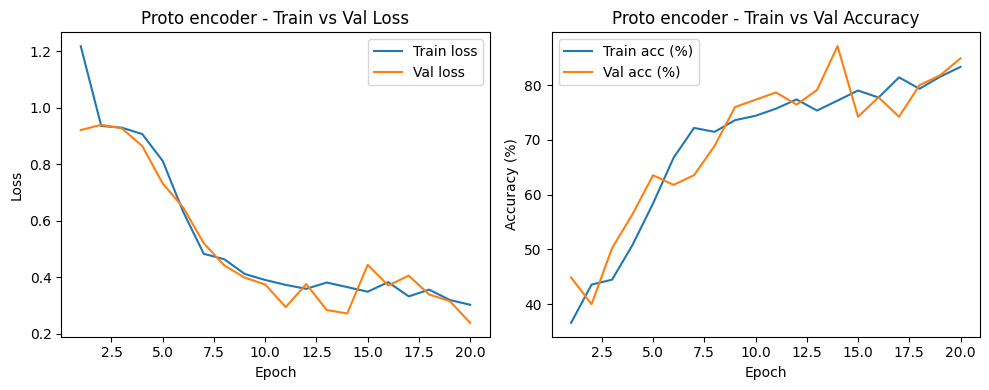

In [36]:
# load courbes
train_loss_hist = np.load(os.path.join(LOSS_DIR, train_loss_name))
val_loss_hist = np.load(os.path.join(LOSS_DIR, val_loss_name))
train_acc_hist = np.load(os.path.join(LOSS_DIR, train_acc_name))
val_acc_hist = np.load(os.path.join(LOSS_DIR, val_acc_name))

epochs_arr = np.arange(1, len(train_loss_hist) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_arr, train_loss_hist, label="Train loss")
plt.plot(epochs_arr, val_loss_hist, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Proto encoder - Train vs Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_arr, train_acc_hist*100, label="Train acc (%)")
plt.plot(epochs_arr, val_acc_hist*100, label="Val acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Proto encoder - Train vs Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [37]:

# --- load weights
model_proto_loaded = Reseau().to(device)
model_proto_loaded.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, model_pth_name), map_location=device))
model_proto_loaded.eval()
print("Loaded model:", os.path.join(WEIGHTS_DIR, model_pth_name))

@torch.no_grad()
def compute_prototypes(
    model,
    enroll_dataset,
    labels=(6, 7, 8, 9, 10, 11),
    n_shots=None,
    batch_size=256,
    device="cuda",
    seed=0,
):
    model.eval()
    dl = DataLoader(enroll_dataset, batch_size=batch_size, shuffle=False)

    sums = {k: None for k in labels}
    counts = {k: 0 for k in labels}

    shot_indices = None
    if n_shots is not None:
        g = torch.Generator().manual_seed(seed)
        shot_indices = {}
        for k in labels:
            idx_k = torch.where(enroll_dataset.labels == k)[0]
            if idx_k.numel() < n_shots:
                raise ValueError(f"Not enough enroll samples for label {k}: {idx_k.numel()} < {n_shots}")
            perm = idx_k[torch.randperm(idx_k.numel(), generator=g)[:n_shots]]
            shot_indices[k] = set(perm.tolist())

    global_idx = 0
    for x, snr, y in dl:
        b = x.shape[0]
        x = x.float().to(device)
        snr = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr)

        for k in labels:
            mask = (y == k)

            if shot_indices is not None and mask.any():
                idxs = torch.arange(global_idx, global_idx + b, device=device)[mask]
                keep = torch.tensor([i.item() in shot_indices[k] for i in idxs], device=device, dtype=torch.bool)
                z_k = z[mask][keep] if keep.any() else None
            else:
                z_k = z[mask] if mask.any() else None

            if z_k is not None and z_k.numel() > 0:
                sums[k] = z_k.sum(dim=0) if sums[k] is None else (sums[k] + z_k.sum(dim=0))
                counts[k] += z_k.shape[0]

        global_idx += b

    prototypes = {}
    for k in labels:
        if counts[k] == 0:
            raise ValueError(f"Prototype for label {k} has 0 samples.")
        prototypes[k] = (sums[k] / counts[k]).detach().cpu()

    return prototypes

@torch.no_grad()
def evaluate_with_prototypes(
    model,
    test_dataset,
    prototypes,
    batch_size=256,
    device="cuda",
):
    model.eval()

    labels = sorted(prototypes.keys())                     # [6..11]
    proto_mat = torch.stack([prototypes[k] for k in labels], dim=0).to(device)  # (C, d)
    label_tensor = torch.tensor(labels, device=device, dtype=torch.long)         # (C,)

    dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    per_label = {k: {"correct": 0, "total": 0} for k in labels}

    # pour confusion matrix (6..11 affichés)
    C = len(labels)
    cm = torch.zeros(C, C, dtype=torch.long)
    lab2i = {lab: i for i, lab in enumerate(labels)}

    for x, snr, y in dl:
        x = x.float().to(device)
        snr = snr.float().to(device).unsqueeze(1)
        y = y.long().to(device)

        z, _ = model(x, snr)

        dists = torch.cdist(z, proto_mat) ** 2            # (B, C)
        pred = label_tensor[dists.argmin(dim=1)]          # (B,) in {6..11}

        total += y.numel()
        correct += (pred == y).sum().item()

        # per-label
        for k in labels:
            m = (y == k)
            if m.any():
                per_label[k]["total"] += m.sum().item()
                per_label[k]["correct"] += (pred[m] == y[m]).sum().item()

        # confusion matrix (CPU)
        pred_cpu = pred.detach().cpu().tolist()
        y_cpu = y.detach().cpu().tolist()
        for yt, yp in zip(y_cpu, pred_cpu):
            cm[lab2i[yt], lab2i[yp]] += 1

    acc = correct / total
    per_label_acc = {k: per_label[k]["correct"] / per_label[k]["total"] for k in labels}
    return acc, per_label_acc, cm.numpy(), labels


Loaded model: /Users/rplanchon/Documents/MVA/Cours/S1/DeepSignal/projet/runs/500_epoch/weights/proto_encoder_Ns5_Nq15_Nc5.pth



Overall acc (prototypes, Z=1 | Z_eff=1): 0.3840 (38.40%)
Per-label acc: {6: 0.13333333333333333, 7: 0.5405405405405406, 8: 0.7792207792207793, 9: 0.5280898876404494, 10: 0.25301204819277107, 11: 0.13793103448275862}


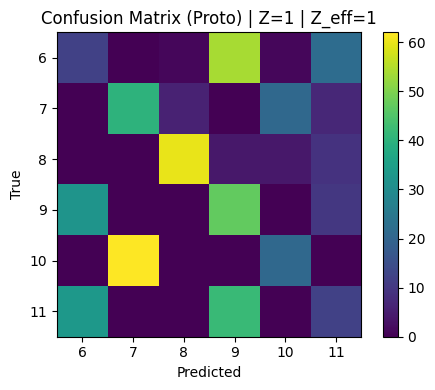


Overall acc (prototypes, Z=5 | Z_eff=5): 0.5020 (50.20%)
Per-label acc: {6: 0.26666666666666666, 7: 0.6486486486486487, 8: 0.8051948051948052, 9: 0.38202247191011235, 10: 0.4578313253012048, 11: 0.5172413793103449}


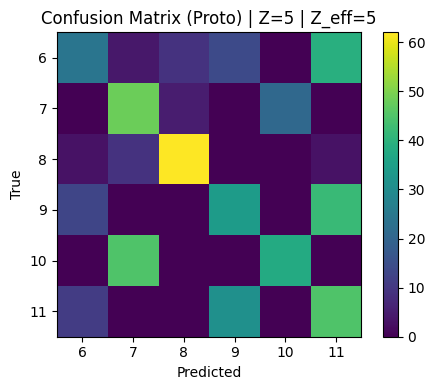


Overall acc (prototypes, Z=10 | Z_eff=10): 0.5240 (52.40%)
Per-label acc: {6: 0.4888888888888889, 7: 0.581081081081081, 8: 0.8441558441558441, 9: 0.42696629213483145, 10: 0.5421686746987951, 11: 0.3103448275862069}


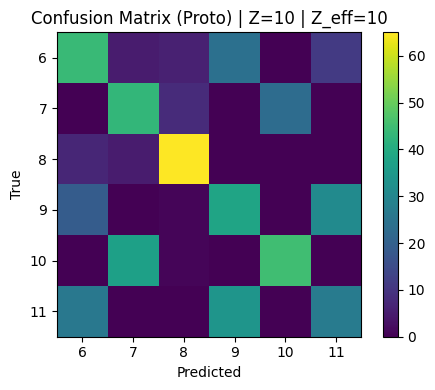


Overall acc (prototypes, Z=20 | Z_eff=20): 0.5360 (53.60%)
Per-label acc: {6: 0.4444444444444444, 7: 0.6081081081081081, 8: 0.8051948051948052, 9: 0.3707865168539326, 10: 0.5662650602409639, 11: 0.47126436781609193}


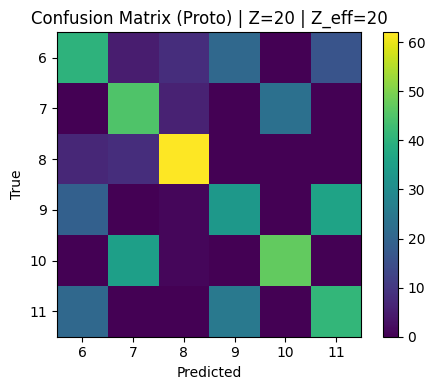


Overall acc (prototypes, Z=50 | Z_eff=50): 0.4820 (48.20%)
Per-label acc: {6: 0.4888888888888889, 7: 0.5135135135135135, 8: 0.8571428571428571, 9: 0.3258426966292135, 10: 0.46987951807228917, 11: 0.28735632183908044}


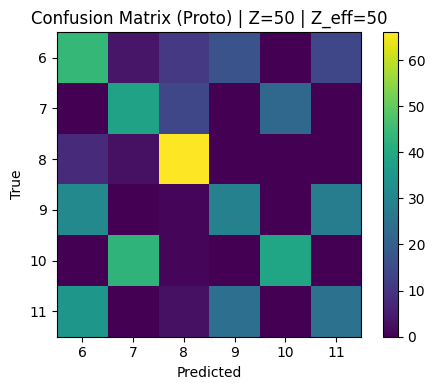


Overall acc (prototypes, Z=100 | Z_eff=None): 0.4920 (49.20%)
Per-label acc: {6: 0.5, 7: 0.527027027027027, 8: 0.8831168831168831, 9: 0.30337078651685395, 10: 0.4457831325301205, 11: 0.3448275862068966}


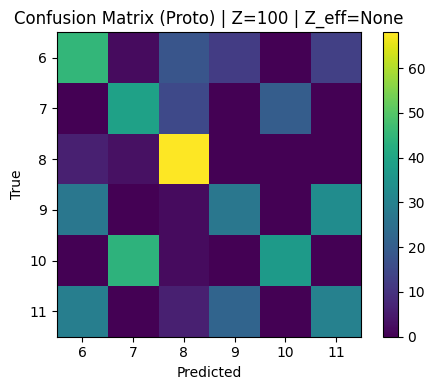

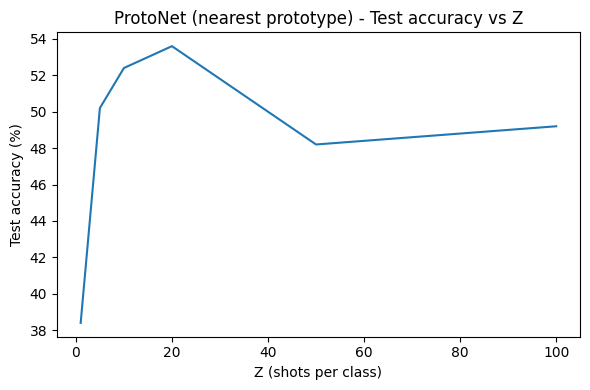

In [40]:
# --- test prototypes pour les mêmes Z que max_samples (baseline)
max_samples = [1, 5, 10, 20, 50, 100]

dataset_enroll = MyDataset(sample_path)   # labels 6..11
dataset_test_fs = MyDataset(test_path)    # labels 6..11

Z_list = []
acc_list = []
gap_list = []  # optionnel si tu veux comparer à une train acc (ici pas de train acc directe)

for Z in max_samples:

    # si Z trop grand -> on met None (= use all enroll samples per class)
    min_per_class = min([int((dataset_enroll.labels == k).sum().item()) for k in [6,7,8,9,10,11]])
    Z_eff = None if Z > min_per_class else Z

    prototypes = compute_prototypes(
        model_proto_loaded,
        dataset_enroll,
        labels=(6,7,8,9,10,11),
        n_shots=Z_eff,
        device=device
    )

    acc, per_label_acc, cm, display_labels = evaluate_with_prototypes(
        model_proto_loaded, dataset_test_fs, prototypes, device=device
    )

    Z_list.append(Z)
    acc_list.append(float(acc))

    print(f"\nOverall acc (prototypes, Z={Z} | Z_eff={Z_eff}): {acc:.4f} ({acc*100:.2f}%)")
    print("Per-label acc:", per_label_acc)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix (Proto) | Z={Z} | Z_eff={Z_eff}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(display_labels)), display_labels)
    plt.yticks(range(len(display_labels)), display_labels)
    plt.tight_layout()
    plt.show()

# courbe acc test vs Z
plt.figure(figsize=(6,4))
plt.plot(Z_list, np.array(acc_list)*100)
plt.xlabel("Z (shots per class)")
plt.ylabel("Test accuracy (%)")
plt.title("ProtoNet (nearest prototype) - Test accuracy vs Z")
plt.tight_layout()
plt.show()
